## 导入所需模块

In [1]:
import numpy as np
import pandas as pd
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
from sklearn.metrics import accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score,auc
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,matthews_corrcoef,roc_auc_score
import matplotlib.pyplot as plt
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg 

## 数据导入

In [154]:
BATCH_SIZE = 32
np_test = np.load("test.npy")
np_train = np.load('train.npy')
#改维度，(numbers,channels,height,width)
np_test = np.reshape(np_test,(5000,1,28,28))
np_train = np.reshape(np_train,(30000,1,28,28))
train_label = pd.read_csv('train.csv')
train_label = train_label['label']
train_label = train_label.values #得到训练集标签
##显示导入的图片
# tr =  np.load('train.npy')
# tr = np.reshape(np_train,(30000,1,28,28)).astype(float)
# plt.imshow(tr[10][0],cmap='gray') # 显示灰度图片
# plt.axis('off') # 不显示坐标轴
# plt.show()

### 数据图片显示

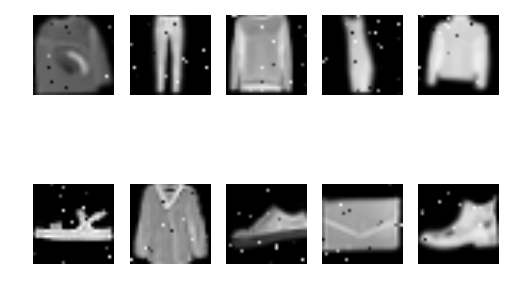

In [155]:
tr =  np.load('train.npy')
tr = np.reshape(np_train,(30000,1,28,28)).astype(float)
for i in range(10):
    plt.subplot(2,5,i+1)
    index = np.argwhere(train_label==i)
    img = tr[index[0]][0]
    plt.imshow(img[0],cmap='gray') # 显示灰度图片
    plt.axis('off') # 不显示坐标轴
plt.savefig('10classedimg')
plt.show()

### 全部训练

In [99]:
#30000个数据全部用来训练，但这样无法查看测试效果
test_tensor = torch.from_numpy(np_test)#转为tensor型
train_tensor = torch.from_numpy(np_train)
trainlabel_tensor = torch.from_numpy(train_label)
trainlabel_tensor = torch.LongTensor(train_label)
#建一个空的test标签来存test的输出
testlabel_tensor = torch.from_numpy(np.zeros(5000))
#转one-hot的尝试
#one_hot = torch.zeros(30000, 10).scatter_(1, trainlabel_tensor.unsqueeze(-1), 1)
train_dataset = Data.TensorDataset(train_tensor,trainlabel_tensor)
test_dataset = Data.TensorDataset(test_tensor,testlabel_tensor)
#得到dataloder
#尝试自己写dataloder来做数据增强！！！
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

### 分割出20%的数据进行测试

In [158]:
x_train,x_test,y_train,y_test = train_test_split(np_train,train_label,test_size=0.2,random_state=42)
#转成tensor
test_tensor = torch.from_numpy(x_test)
testlabel_tensor = torch.from_numpy(y_test)
train_tensor = torch.from_numpy(x_train)
trainlabel_tensor = torch.from_numpy(y_train)
train_dataset = Data.TensorDataset(train_tensor,trainlabel_tensor)
test_dataset = Data.TensorDataset(test_tensor,testlabel_tensor)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

## 数据增强

In [169]:
from PIL import Image  
import cv2
BATCH_SIZE = 32
mytransform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),#图像左右翻转
        transforms.RandomGrayscale(),     #灰度随机变换
        #transforms.Normalize(0.47,0.2),
        transforms.ToTensor() 
        ##标准化？
    ])

### 全部训练集都加强，不分预测集

In [171]:
#全部训练集用来训练的数据加强
class myDateset(Data.Dataset):
    def __init__(self,transform=None,train=np.ones(shape=(30000,1,28,28)),label=np.ones(shape=(30000))):
        self.x = torch.from_numpy(train)
        self.y = torch.from_numpy(label)
        self.transform = transform
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return len(self.x)

class myDateset_test(Data.Dataset):
    def __init__(self,transform=None,train=np.ones(shape=(5000,1,28,28)),label=np.ones(shape=(5000))):
        self.x = torch.from_numpy(train)
        self.y = torch.from_numpy(label)
        self.transform = transform
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return len(self.x)

for i in range(30000):
    np_train[i][0] = cv2.medianBlur(np_train[i][0],3) #每张图中值滤波去噪点

for i in range(5000):
    np_test[i][0] =cv2.medianBlur(np_test[i][0],3)

    

processeddataset = myDateset(transform=mytransform,train=np_train,label=train_label)
testdataset = myDateset_test(transform=mytransform,train=np_test,label=np.zeros(5000))
train_loader = Data.DataLoader(dataset=processeddataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=testdataset,batch_size=BATCH_SIZE,shuffle=False)

### 分割出一部分训练集的数据集加强

In [160]:
#分割出的训练集和测试集的数据加强

class myDateset(Data.Dataset):
    def __init__(self,transform=None,train=np.ones(shape=(24000,1,28,28)),label=np.ones(shape=(24000))):
        self.x = torch.from_numpy(train)
        self.y = torch.from_numpy(label)
        self.transform = transform
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return len(self.x)

class myDateset_test(Data.Dataset):
    def __init__(self,transform=None,train=np.ones(shape=(6000,1,28,28)),label=np.ones(shape=(6000))):
        self.x = torch.from_numpy(train)
        self.y = torch.from_numpy(label)
        self.transform = transform
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return len(self.x)

for i in range(24000):
    x_train[i][0] = cv2.medianBlur(x_train[i][0],3) #每张图中值滤波去噪点

for i in range(6000):
    x_test[i][0] = cv2.medianBlur(x_test[i][0],3)

    

processeddataset = myDateset(transform=mytransform,train=x_train,label=y_train)
testdataset = myDateset_test(transform=mytransform,train=x_test,label=y_test)
train_loader = Data.DataLoader(dataset=processeddataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=testdataset,batch_size=BATCH_SIZE,shuffle=False)

### 增强效果

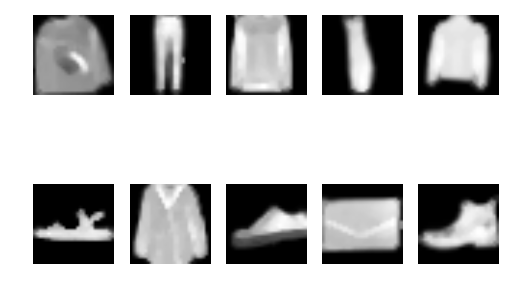

In [152]:
# processeddataset.x[0][0].shape
# plt.imshow(x_train[10][0],cmap='gray') # 显示灰度图片
# img1 = x_train[10][0]
# plt.axis('off') # 不显示坐标轴
# plt.show()
# plt.imshow(processeddataset.x[10][0],cmap='gray') # 显示灰度图片
# plt.axis('off') # 不显示坐标轴
# plt.show()
# median = cv2.medianBlur(img1,3)
# plt.imshow(median)
# plt.show()
for i in range(10):
    plt.subplot(2,5,i+1)
    index = np.argwhere(train_label==i)
    img = processeddataset.x[index[0]][0]
    plt.imshow(img[0],cmap='gray') # 显示灰度图片
    plt.axis('off') # 不显示坐标轴
plt.savefig('reinforce')
plt.show()

In [103]:
## 将图片转成3个通道的尝试，最后没有采用
# trainx = np.zeros(shape=(24000,28,28,3))
# for i in range(24000):
#     x_train[i][0] = cv2.medianBlur(x_train[i][0],3) #每张图中值滤波去噪点
#     img = Image.fromarray(x_train[i][0])
#     img = img.convert('RGB')
#     ar = np.array(img)
#     trainx[i] = ar

# testx = np.zeros(shape=(6000,28,28,3))
# for i in range(6000):
#     x_test[i][0] = cv2.medianBlur(x_test[i][0],3)
#     img = Image.fromarray(x_test[i][0])
#     img = img.convert('RGB')
#     ar = np.array(img)
#     testx[i] = ar
# np_test.shape

(5000, 1, 28, 28)

## 搭建网络

### VGG网络

In [57]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(1,64,1,padding=1)#(32,1,28,28)->(32,64,28,28)?
        self.conv2 = nn.Conv2d(64,64,3,padding=1)#(32,64,28,28)->(32,64,28,28)
        self.pool1 = nn.MaxPool2d(2,2)#(32,64,28,28)->(32,64,14,14)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)#(32,128,14,14)->(32,128,14,14)
        self.pool2 = nn.MaxPool2d(2,2,padding=1)#(32,128,14,14)->(32,128,8,8)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        
        self.fc5 = nn.Linear(128*8*8,512)
        self.drop1 = nn.Dropout2d()#防止过拟合
        self.fc6 = nn.Linear(512,10)#输出是10维代表10类
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop1(x)
        
        x = x.view(-1,128*8*8) #将维度展成128*8*8以便进行线性拟合
        x = F.relu(self.fc5(x))
        x = self.drop1(x)
        x = self.fc6(x)
        
        return x

In [161]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(1,64,1,padding=1)#(32,1,28,28)->(32,64,28,28)?
        self.conv2 = nn.Conv2d(64,64,3,padding=1)#(32,64,28,28)->(32,64,28,28)
        self.pool1 = nn.MaxPool2d(2,2)#(32,64,28,28)->(32,64,14,14)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)#(32,128,14,14)->(32,128,14,14)
        self.pool2 = nn.MaxPool2d(2,2,padding=1)#(32,128,14,14)->(32,128,8,8)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        self.conv6 = nn.Conv2d(256,256,3,padding=1)#(32,128,14,14)->(32,128,14,14)
        self.pool3 = nn.MaxPool2d(2,2,padding=1)#(32,128,14,14)->(32,128,8,8)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        
        self.conv7 = nn.Conv2d(256,512,3,padding=1)
        self.conv8 = nn.Conv2d(512,512,3,padding=1)#(32,128,14,14)->(32,128,14,14)
        self.pool4 = nn.MaxPool2d(2,2,padding=1)#(32,128,14,14)->(32,128,8,8)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(512*3*3,512)
        self.drop1 = nn.Dropout2d()#防止过拟合
        self.fc6 = nn.Linear(512,10)#输出是10维代表10类
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop1(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop1(x)
        
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop1(x)
        
        x = x.view(-1,512*3*3) #将维度展成128*8*8以便进行线性拟合
        x = F.relu(self.fc5(x))
        x = self.drop1(x)
        x = self.fc6(x)
        
        return x

In [162]:
model = Model()#.cuda() #实例化卷积层
model.cuda() 
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
loss.cuda()
optimizer = optim.Adam(model.parameters(),lr=0.001)
#optimizer = optim.SGD(model.parameters(),lr = 0.001)
num_epochs = 50

### ResNet18网络

In [172]:
class ResidualBlock(nn.Module):#残差模块
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:#确保输出的通道数和输入一样多，才能计算残差
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
        self.drop1 = nn.Dropout2d(0.2)#防止过拟合
        

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.drop1(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)

In [173]:
model = ResNet18()#.cuda() #实例化卷积层
model.cuda() 
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
loss.cuda()
optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum=0.8) #初始学习率为0.01,利用了momentum
#optimizer = optim.Adam(model.parameters(),lr=0.001)
num_epochs = 50

## 训练

In [174]:
losses = [] 
acces = []
eval_losses = []
eval_acces = []
def adjust_learning_rate(optimizer,epoch):
    #lr = args.lr*(0.1**(epoch//10)) #每10个epoch学习率变为原来的1/10
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        lr = lr*(0.1**(epoch//10))
        param_group['lr'] = lr

for echo in range(num_epochs):
    train_loss = 0   #定义训练损失
    train_acc = 0    #定义训练准确度
    #adjust_learning_rate(optimizer,echo)##学习率衰减
    model.train()    #将网络转化为训练模式
    for i,(X,label) in enumerate(train_loader):     #使用枚举函数遍历train_loader
        #X = X.view(-1,784)       #X:[64,1,28,28] -> [64,784]将X向量展平
        X = Variable(X.float()).cuda()          #包装tensor用于自动求梯度
        label = Variable(label).cuda()
        out = model(X)           #正向传播
        lossvalue = loss(out,label)         #求损失值
        optimizer.zero_grad()       #优化器梯度归零
        lossvalue.backward()    #反向转播，刷新梯度值
        optimizer.step()        #优化器运行一步，注意optimizer搜集的是model的参数
        
        #计算损失
        train_loss += float(lossvalue)      
        #计算精确度
        _,pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    print("echo:"+' ' +str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("accuracy:" + ' '+str(train_acc / len(train_loader)))
    if train_loss / len(train_loader)<0.183:
        break
    

echo: 0
lose: 0.8996731065737922
accuracy: 0.6623134328358209
echo: 1
lose: 0.6712882188337443
accuracy: 0.7346415245202559
echo: 2
lose: 0.5955849514523549
accuracy: 0.7601945628997868
echo: 3
lose: 0.5437717836961817
accuracy: 0.7739538912579957
echo: 4
lose: 0.5034569650729582
accuracy: 0.7878797974413646
echo: 5
lose: 0.45932450307521233
accuracy: 0.8044043176972282
echo: 6
lose: 0.42244813722302155
accuracy: 0.8130663646055437
echo: 7
lose: 0.39188302337710285
accuracy: 0.8251265991471215
echo: 8
lose: 0.3601878338308731
accuracy: 0.8350213219616205
echo: 9
lose: 0.3339463644412789
accuracy: 0.8443496801705757
echo: 10
lose: 0.31162250890875104
accuracy: 0.853578091684435
echo: 11
lose: 0.292756364619268
accuracy: 0.8562100213219617
echo: 12
lose: 0.269999323496178
accuracy: 0.8635394456289979
echo: 13
lose: 0.26121848063078773
accuracy: 0.8701026119402985
echo: 14
lose: 0.2486896089750773
accuracy: 0.8714019189765458
echo: 15
lose: 0.23542488431895592
accuracy: 0.8755996801705757

## 评估预测

In [175]:
# eval_loss = 0
# eval_acc = 0
label_all = None
pred_all = None
pred_pro_all = None
model.eval() #模型转化为评估模式
for X,label in test_loader:
    #X = X.view(-1,784)
    X = Variable(X).cuda()
    label = Variable(label.long()).cuda()
    #model.cuda()
    with torch.no_grad():
        testout = model(X.float())
    testloss = loss(testout,label)
    #eval_loss += float(testloss)

    _, pred = testout.max(1)
    if label_all is None:
        label_all = label
    else:
        label_all = torch.cat([label_all,label])

    if pred_all is None:
        pred_all = torch.cat([pred])
    else:
        pred_all = torch.cat([pred_all,pred])

    if pred_pro_all is None:
        pred_pro_all = torch.cat([F.sigmoid(testout)])
    else:
        pred_pro_all = torch.cat([pred_pro_all,F.sigmoid(testout)])
#     num_correct = (pred == label).sum()
#     acc = int(num_correct) / X.shape[0]
#     eval_acc += acc

y_test = label_all.cpu().detach().numpy()
#print(y_test)
y_pred = pred_all.cpu().detach().numpy()
#print(y_pred)
y_pred_pro = pred_pro_all.cpu().detach().numpy()

E:\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [176]:
print('ACC:%.7f' %accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision-macro:%.7f' %precision_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('Recall-macro:%.7f' %recall_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('F1-macro:%.7f' %f1_score(y_true=y_test, y_pred=y_pred,average='macro')) 
#全部数据都用来训练了，这里的标签值全0，所以真确率低
#分割好数据集就可以用来测试训练的精度了

ACC:0.0952000
Precision-macro:0.1000000
Recall-macro:0.0095200
F1-macro:0.0173850


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 处理预测数据

In [178]:
y_arr = y_pred;
index = np.arange(0,5000,1);
y_arr = y_arr.reshape(5000,1);
index = index.reshape(5000,1);
#index.shape
y_preday = np.hstack((index,y_arr));
y_preday
y_preddf = pd.DataFrame(y_preday)
y_preddf
tr_label = pd.read_csv('train.csv');
y_preddf.columns=['image_id','label'];
y_preddf
y_preddf.to_csv('test4.csv', sep=',', header=True, index=False)
#tr_label

## 结果可视化

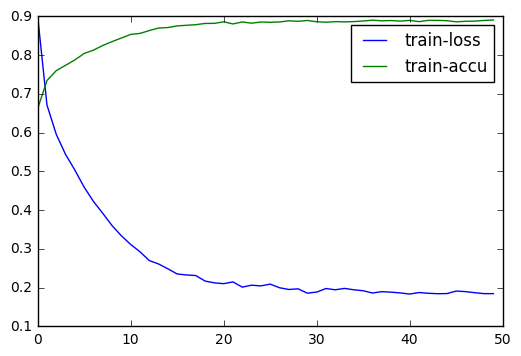

In [177]:
lossval = np.array(losses)
accuracy = np.array(acces)
# plt.figure()
epoch = np.arange(0,50)
plt.plot(epoch,lossval,label='train-loss')
plt.plot(epoch,accuracy,label='train-accu')
plt.legend()
plt.savefig('result')
plt.show()